In [1]:
from sklearn.datasets import make_moons

In [2]:
X, y = make_moons(n_samples=1000, random_state=42)

In [3]:
X

array([[ 0.00872719,  0.36817352],
       [ 0.921384  , -0.49690497],
       [ 0.94022577, -0.49821192],
       ...,
       [ 1.64091013, -0.26761592],
       [-0.91991616,  0.39211512],
       [ 0.80079841,  0.59893397]])

In [4]:
y

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,

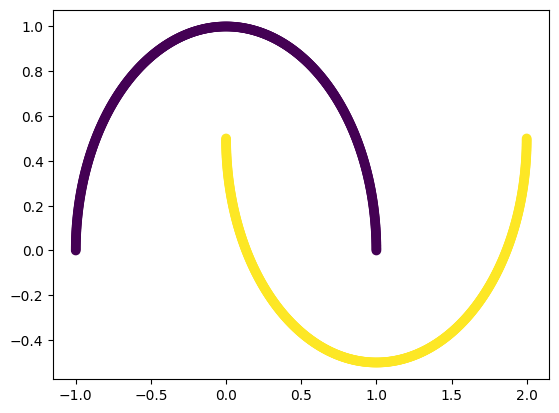

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0], y=X[:,1], c=y)

In [6]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
X = torch.from_numpy(X).to(device)
y = torch.from_numpy(y).to(device)

In [8]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state = 42)

In [9]:
len(Xtrain), len(Xtest)

(800, 200)

In [11]:
Xtrain.shape, Ytrain.shape

(torch.Size([800, 2]), torch.Size([800]))

In [52]:
inp_f = 2
opt_f = 1
hid_u = 30

In [57]:
torch.manual_seed(42)
class MoonModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_stacks = nn.Sequential(
        nn.Linear(in_features = inp_f, out_features = hid_u),
        nn.ReLU(),
        nn.Linear(in_features = hid_u, out_features = hid_u),
        nn.ReLU(),
        nn.Linear(in_features = hid_u, out_features = opt_f),
    )
  def forward(self, x):
    return self.layer_stacks(x)

model = MoonModel().to(device)
model

MoonModel(
  (layer_stacks): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [58]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [59]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

acc_fn = Accuracy(num_classes = 2).to(device)

In [61]:
torch.manual_seed(42)
epochs = 1000
Xtrain, Ytrain, Xtest, Ytest =  Xtrain.type(torch.float32), Ytrain.type(torch.float32), Xtest.type(torch.float32), Ytest.type(torch.float32)
Ytrain.squeeze()
Ytest.squeeze()
for epoch in range(epochs):
  model.train()
  trainLogits = model(Xtrain).squeeze()
  trainPreds = torch.round(torch.sigmoid(trainLogits)).long()
  trainLoss = loss_fn(trainLogits, Ytrain)
  train_acc = acc_fn(trainPreds, Ytrain.long())

  optimizer.zero_grad()
  trainLoss.backward()
  optimizer.step()
  model.eval()

  with torch.inference_mode():
    testLogits = model(Xtest).squeeze()
    testPreds = torch.round(torch.sigmoid(testLogits)).long()
    testLoss = loss_fn(testLogits, Ytest)
    test_acc = acc_fn(testPreds, Ytest.long())

  if epoch%10==0:
    print(f"Epoch : {epoch} | Train Loss : {trainLoss:.5f} | Train Accuracy : {train_acc*100:.2f}% | Test Loss : {testLoss:.5f} | Test Accuracy : {test_acc*100:.2f}%")

Epoch : 0 | Train Loss : 0.00197 | Train Accuracy : 100.00% | Test Loss : 0.00188 | Test Accuracy : 100.00%
Epoch : 10 | Train Loss : 0.00192 | Train Accuracy : 100.00% | Test Loss : 0.00183 | Test Accuracy : 100.00%
Epoch : 20 | Train Loss : 0.00187 | Train Accuracy : 100.00% | Test Loss : 0.00179 | Test Accuracy : 100.00%
Epoch : 30 | Train Loss : 0.00183 | Train Accuracy : 100.00% | Test Loss : 0.00174 | Test Accuracy : 100.00%
Epoch : 40 | Train Loss : 0.00178 | Train Accuracy : 100.00% | Test Loss : 0.00170 | Test Accuracy : 100.00%
Epoch : 50 | Train Loss : 0.00174 | Train Accuracy : 100.00% | Test Loss : 0.00166 | Test Accuracy : 100.00%
Epoch : 60 | Train Loss : 0.00170 | Train Accuracy : 100.00% | Test Loss : 0.00162 | Test Accuracy : 100.00%
Epoch : 70 | Train Loss : 0.00166 | Train Accuracy : 100.00% | Test Loss : 0.00158 | Test Accuracy : 100.00%
Epoch : 80 | Train Loss : 0.00162 | Train Accuracy : 100.00% | Test Loss : 0.00154 | Test Accuracy : 100.00%
Epoch : 90 | Train L

In [62]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

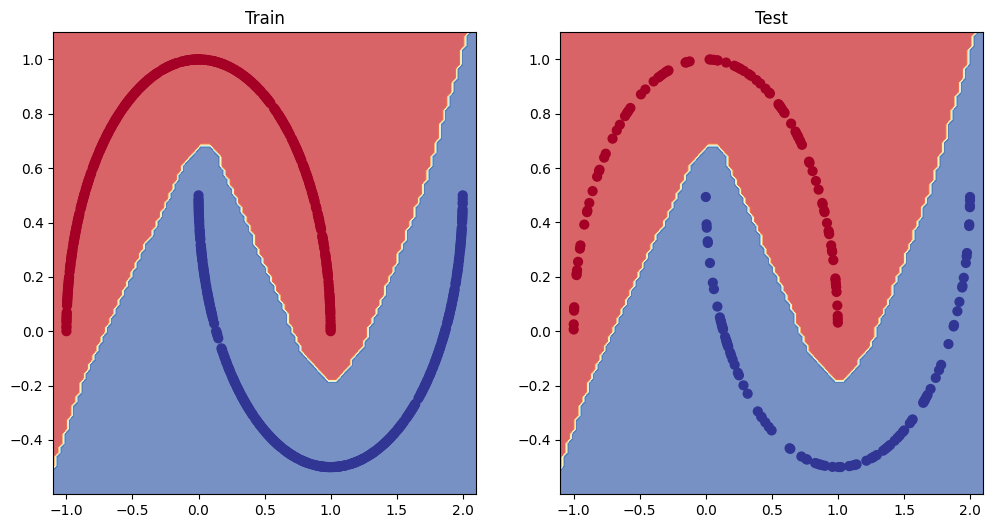

In [63]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, Xtrain, Ytrain)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, Xtest, Ytest)